Importing the required libraries

In [18]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score


loading the data

In [3]:
df=pd.read_csv('listings.csv')

In [4]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Cannot see all the column names along with the data types it contains.

Lets see the percentage of nulls in each column

In [5]:
for i in df.columns:
    print(f"{i:<32}" +' %  Nulls: ' + f"{str(int((df[i].isnull().sum()/len(df))*100)) : >10}")

id                               %  Nulls:          0
listing_url                      %  Nulls:          0
scrape_id                        %  Nulls:          0
last_scraped                     %  Nulls:          0
name                             %  Nulls:          0
summary                          %  Nulls:          4
space                            %  Nulls:         14
description                      %  Nulls:          0
experiences_offered              %  Nulls:          0
neighborhood_overview            %  Nulls:         27
notes                            %  Nulls:         42
transit                          %  Nulls:         24
thumbnail_url                    %  Nulls:          8
medium_url                       %  Nulls:          8
picture_url                      %  Nulls:          0
xl_picture_url                   %  Nulls:          8
host_id                          %  Nulls:          0
host_url                         %  Nulls:          0
host_name                   

Many columns have data that provide no value and no value can be extracted through feature engineering.

Will do an initial drop and inspect the rest of the columns accordingly

In [6]:
df=df.drop(['listing_url','thumbnail_url','medium_url' , 'picture_url','xl_picture_url','scrape_id','last_scraped',
            'experiences_offered','picture_url','requires_license','license','jurisdiction_names','state','city','market'
            ,'smart_location','country_code','country','longitude','latitude','square_feet','has_availability',
            'calendar_last_scraped','host_url','host_name','host_location','host_about','host_thumbnail_url',
            'host_picture_url','street','availability_30','availability_60','availability_90','first_review',
            'last_review','minimum_nights','maximum_nights','extra_people'],axis=1)

Lets look at the data types

In [7]:
for i in df.columns:
    print(f"{i:<32}" +'  : '+ str(df[i].dtypes))

id                                : int64
name                              : object
summary                           : object
space                             : object
description                       : object
neighborhood_overview             : object
notes                             : object
transit                           : object
host_id                           : int64
host_since                        : object
host_response_time                : object
host_response_rate                : object
host_acceptance_rate              : object
host_is_superhost                 : object
host_neighbourhood                : object
host_listings_count               : float64
host_total_listings_count         : float64
host_verifications                : object
host_has_profile_pic              : object
host_identity_verified            : object
neighbourhood                     : object
neighbourhood_cleansed            : object
neighbourhood_group_cleansed      : object
zipcode    

Many numerical columns are formated as objects, will need to change them to float for easier exploration

In [8]:
def numeric_converter(df):
    for i in df.columns:
        df[i]=df[i].str.strip('% $ ,')
        df[i]=df[i].str.replace(',', '')
        df[i]=pd.to_numeric(df[i],downcast='float')
    return df

df[['host_response_rate','price','security_deposit','cleaning_fee']]=numeric_converter(df[['host_response_rate','price','security_deposit','cleaning_fee']])



<ipython-input-8-4f2d9ed253f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].str.strip('% $ ,')
<ipython-input-8-4f2d9ed253f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].str.replace(',', '')
<ipython-input-8-4f2d9ed253f3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Instead of dropping the below columns directly, will try to see if there's a correlation between a positive language and the unit price

The below columns have no sentiment as per definition, so will check if the more a person describes the unit the higher the demand and therefore the price

In [9]:
cols=['notes','transit']

In [10]:
for i in cols:
    df[i]=df[i].str.len()

In [11]:
df_sent1=df[['id','name','summary','space','description']]

Filling the nulls with a neutral word because the sentiment analyzer does not work with nulls

In [12]:
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_since,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,956883,2011-08-11,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",1000.0,162.0,5177328,2013-02-21,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,155.0,202.0,16708587,2014-06-12,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,9851441,2013-11-06,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,9.0,295.0,1452570,2011-11-29,...,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


In [13]:
df_sent1=df_sent1.fillna('none')

Defining a function and using it to replace each of the columns defined above in (df_sent1) with their sentiment value

There seem to be no correlation between any of the above columns and price

In [14]:
#plt.scatter(x=analyzed_df['description'],y=df['price']);
#analyzed_df['description'].corr(df['price'])

C:\Users\ajax2\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-15-dda7179e2eb7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin


-0.020269655985929252

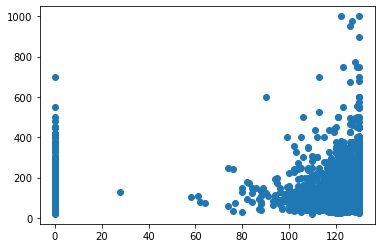

In [15]:
df1= df[['id', 'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value']]
df1.fillna(0,inplace=True)

df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin
+df1.review_scores_communication+df1.review_scores_value;

plt.scatter(x=df1['review_scores_total'],y=df['price']);
df1['review_scores_total'].corr(df['price'])

Drop the columns as they provide no value

In [16]:
df=df.drop(['name','summary','space','description','notes','transit','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value','review_scores_location','neighborhood_overview'],axis=1)

Create a function that splits columns with multiple strings into separate columns and another function to count them

In [17]:
def str_split(df,col):
    
    df[col]=df[col].str.replace('"','')
    df[col]=df[col].str.strip(" []''")
    df=df[col].str.split(',',expand=True)
    
    return df

def row_count(df):    
    df['count']=df.apply(lambda x: x.count(), axis=1)
    return df

Use the above two functions on the Amenities column to check if there's a correlation between the number of amenities and price

In [126]:
df2=df[['amenities']]
df2

,amenities
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ..."
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
...,...
3813,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3814,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
3815,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ..."
3816,"{TV,""Wireless Internet"",Kitchen,""Free Parking ..."


In [131]:
str(df2['amenities'][0]).strip('{}').split(',')

['TV',
 '"Cable TV"',
 'Internet',
 '"Wireless Internet"',
 '"Air Conditioning"',
 'Kitchen',
 'Heating',
 '"Family/Kid Friendly"',
 'Washer',
 'Dryer']

In [158]:
def untangle(df):
    for j in range(len(df)):
        for i in str(df['amenities'][j]).strip('{}').split(','): 
            if i not in df.columns:
                df[i][j]=1
            else:
                df[i][j]=0
    return df
        

def labeler(x):
        if x==0:
            return 1
        else:
            return 0

df_amenities= untangle(df2).applymap(labeler)
df_amenities=df_amenities.drop(['amenities'],axis=1)

<ipython-input-158-d0a7fc5553b5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][j]=0


In [160]:
df_amenities.mean()

TV                              0.674175
"Cable TV"                      0.378732
Internet                        0.736249
"Wireless Internet"             0.960450
"Air Conditioning"              0.177318
Kitchen                         0.896543
Heating                         0.949974
"Family/Kid Friendly"           0.514144
Washer                          0.783656
Dryer                           0.784966
"Free Parking on Premises"      0.567575
"Buzzer/Wireless Intercom"      0.140911
"Smoke Detector"                0.859350
"Carbon Monoxide Detector"      0.650864
"First Aid Kit"                 0.440021
"Safety Card"                   0.190414
"Fire Extinguisher"             0.575170
Essentials                      0.847826
"Pets Allowed"                  0.123625
"Pets live on this property"    0.231273
Dog(s)                          0.133316
Cat(s)                          0.100052
"Hot Tub"                       0.079361
"Indoor Fireplace"              0.232059
Shampoo         

In [ ]:
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column],
                        columns='% observations', 
                        normalize='columns'))
    print("# of unique values {}".format(df[column].nunique()))

# show summary statistics
display(df.describe())

# build histograms for each numeric feature
%matplotlib inline
hist = df.hist(bins=30, sharey=False, figsize=(15, 10))

In [ ]:
df.columns

In [161]:
host_ver_df=df[['host_verifications']]

In [162]:
df_dummies=df[['host_response_time','host_is_superhost','host_identity_verified','neighbourhood_cleansed','zipcode',
      'is_location_exact','property_type','room_type','bed_type','instant_bookable','cancellation_policy',
       'require_guest_profile_picture','require_guest_phone_verification']]

In [163]:
df=df.drop(['host_since','host_acceptance_rate','host_neighbourhood','host_has_profile_pic','neighbourhood_group_cleansed',
      'neighbourhood','weekly_price','monthly_price','calendar_updated'],axis=1)

In [164]:
df_numeric=df.select_dtypes(include=['int64','float64','float32','int32'])

df_numeric

,id,host_id,host_response_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,availability_365,calculated_host_listings_count,reviews_per_month
0,241032,956883,96.0,3.0,3.0,4,1.0,1.0,1.0,85.0,NaN,NaN,2,346,2,4.07
1,953595,5177328,98.0,6.0,6.0,4,1.0,1.0,1.0,150.0,100.0,40.0,1,291,6,1.48
2,3308979,16708587,67.0,2.0,2.0,11,4.5,5.0,7.0,975.0,1000.0,300.0,10,220,2,1.15
3,7421966,9851441,NaN,1.0,1.0,3,1.0,0.0,2.0,100.0,NaN,NaN,1,143,1,NaN
4,278830,1452570,100.0,2.0,2.0,6,2.0,3.0,3.0,450.0,700.0,125.0,6,365,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,31148752,99.0,354.0,354.0,6,2.0,3.0,3.0,359.0,NaN,230.0,1,32,8,0.30
3814,8902327,46566046,100.0,1.0,1.0,4,1.0,1.0,2.0,79.0,500.0,50.0,3,273,1,2.00
3815,10267360,52791370,NaN,1.0,1.0,2,1.0,1.0,1.0,93.0,250.0,35.0,2,88,1,NaN
3816,9604740,25522052,100.0,1.0,1.0,2,1.0,0.0,1.0,99.0,300.0,45.0,1,179,1,NaN


In [ ]:
df.shape[1]-df_dummies.shape[1]-df_numeric.shape[1]

In [166]:
df_dummies=pd.concat([df_dummies,df_amenities],axis=1)

In [167]:
df['host_verifications']=row_count(str_split(host_ver_df,'host_verifications'))[:]['count']

In [168]:
df.head()

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_identity_verified,neighbourhood_cleansed,...,security_deposit,cleaning_fee,guests_included,availability_365,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,956883,within a few hours,96.0,f,3.0,3.0,4,t,West Queen Anne,...,NaN,NaN,2,346,f,moderate,f,f,2,4.07
1,953595,5177328,within an hour,98.0,t,6.0,6.0,6,t,West Queen Anne,...,100.0,40.0,1,291,f,strict,t,t,6,1.48
2,3308979,16708587,within a few hours,67.0,f,2.0,2.0,5,t,West Queen Anne,...,1000.0,300.0,10,220,f,strict,f,f,2,1.15
3,7421966,9851441,NaN,NaN,f,1.0,1.0,5,t,West Queen Anne,...,NaN,NaN,1,143,f,flexible,f,f,1,NaN
4,278830,1452570,within an hour,100.0,f,2.0,2.0,5,t,West Queen Anne,...,700.0,125.0,6,365,f,strict,f,f,1,0.89


In [169]:
for i in df.columns:
    print(f"{i:<32}" +'  : '+ str(df[i].dtypes))

id                                : int64
host_id                           : int64
host_response_time                : object
host_response_rate                : float32
host_is_superhost                 : object
host_listings_count               : float64
host_total_listings_count         : float64
host_verifications                : int64
host_identity_verified            : object
neighbourhood_cleansed            : object
zipcode                           : object
is_location_exact                 : object
property_type                     : object
room_type                         : object
accommodates                      : int64
bathrooms                         : float64
bedrooms                          : float64
beds                              : float64
bed_type                          : object
amenities                         : object
price                             : float32
security_deposit                  : float32
cleaning_fee                      : float32
guests

In [170]:
df_dummies=pd.get_dummies(df_dummies,dummy_na=True)

In [171]:
for i in df_dummies.columns:
    print(f"{i:<32}" +'  : '+ str(df_dummies[i].dtypes))

TV                                : int64
"Cable TV"                        : int64
Internet                          : int64
"Wireless Internet"               : int64
"Air Conditioning"                : int64
Kitchen                           : int64
Heating                           : int64
"Family/Kid Friendly"             : int64
Washer                            : int64
Dryer                             : int64
"Free Parking on Premises"        : int64
"Buzzer/Wireless Intercom"        : int64
"Smoke Detector"                  : int64
"Carbon Monoxide Detector"        : int64
"First Aid Kit"                   : int64
"Safety Card"                     : int64
"Fire Extinguisher"               : int64
Essentials                        : int64
"Pets Allowed"                    : int64
"Pets live on this property"      : int64
Dog(s)                            : int64
Cat(s)                            : int64
"Hot Tub"                         : int64
"Indoor Fireplace"                

In [ ]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_numeric.corr(), annot=True)

In [172]:
df_numeric=df_numeric.drop(['id','host_id','availability_365', 'host_response_rate','host_listings_count','host_total_listings_count','calculated_host_listings_count','reviews_per_month'],axis=1)

In [ ]:
pd.plotting.scatter_matrix(df_numeric, figsize=(18,18));

In [ ]:
plt.figure(figsize = (15, 10))
sns.heatmap(df_numeric.corr(), annot=True)

In [173]:
y=df_numeric['price']
df_numeric=df_numeric.drop(['price'],axis=1)

In [174]:
def normalize(df):
    for i in df.columns:
        df[i]=StandardScaler().fit_transform(df[[i]])[:,0]
    return df


In [175]:
df_model=pd.concat([df_numeric,df_dummies],axis=1)

In [289]:
df_model.fillna( df_model.mean() ,inplace=True)

In [290]:
X=df_model


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

lr=LinearRegression()

lr.fit(X_train,y_train)

y_pred=lr.predict(X_test)

r2_score(y_test,y_pred)

In [291]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

lr=LinearRegression()

lr.fit(X_train,y_train)

y_pred=lr.predict(X_test)

r2_score(y_test,y_pred)

0.6095801546699253

In [292]:
RF=RandomForestRegressor(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =42, max_features = "auto",
                                  max_leaf_nodes = 600, max_depth=32, warm_start=True)

RF.fit(X_train,y_train)

y_pred_RF=RF.predict(X_test)

r2_score(y_test,y_pred_RF)

0.6315464341210326

In [216]:
RF.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': 600,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': True}